# DIC Graduation Project
### Solving Real Problems in Sireea Leone Using Machine Learning
### Stroke Prediction dataset In Sierra Leone

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

We first look at our data to see what we're dealing with.  

Some of the steps we can take to understand our data:  
* Get the mean, median, mode
* Check for outliers and missing data
* Form boxplots to view our distribution
  
Formally, the steps we'll take to carry out our prediction are as below:  
1. Understanding the data
2. Cleaning the data
3. Create our prediction models
4. Test and validate our prediction models
5. Conclude with insights

In [2]:
data = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

#We see that we're working with a DataFrame
print(type(data))

#first we check how many datapoints and features we have
print(data.shape)
print(data.columns)

#we use head(10) to check how the data roughly looks like with the first 10 samples
display(data.head(10))

#display column data types 
print(data.columns.to_series().groupby(data.dtypes).groups)


<class 'pandas.core.frame.DataFrame'>
(5110, 12)
Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


{int64: ['id', 'hypertension', 'heart_disease', 'stroke'], float64: ['age', 'avg_glucose_level', 'bmi'], object: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']}


* We can check the statistics for float columns such as age, avg_glucose_level, and bmi.
* We also note that we have missing values in bmi and possibly in other features as well.    
  
Our next steps will be to check for duplicates and missing values then we proceed to get the statistics of our data.


In [3]:
float_cats = data[['age', 'avg_glucose_level', 'bmi']]
display(float_cats.describe())

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


* Participant age ranges from 29 days old to 82 years
* minimum bmi is 10.3 while maximum is 97.6

In [4]:
#Duplicates
duplicates= data.duplicated('id', keep =False)
duplicated_strokes= data[duplicates].sort_values('id')
print(duplicated_strokes)

Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke]
Index: []


So we see that this data set doesn't have duplicated data since the 'extraction' is an empty DataFrame.

id     gender  age    hypertension  heart_disease  ever_married  work_type  Residence_type  avg_glucose_level  bmi    smoking_status  stroke
False  False   False  False         False          False         False      False           False              False  False           False     4909
                                                                                                               True   False           False      201
dtype: int64


<AxesSubplot:>

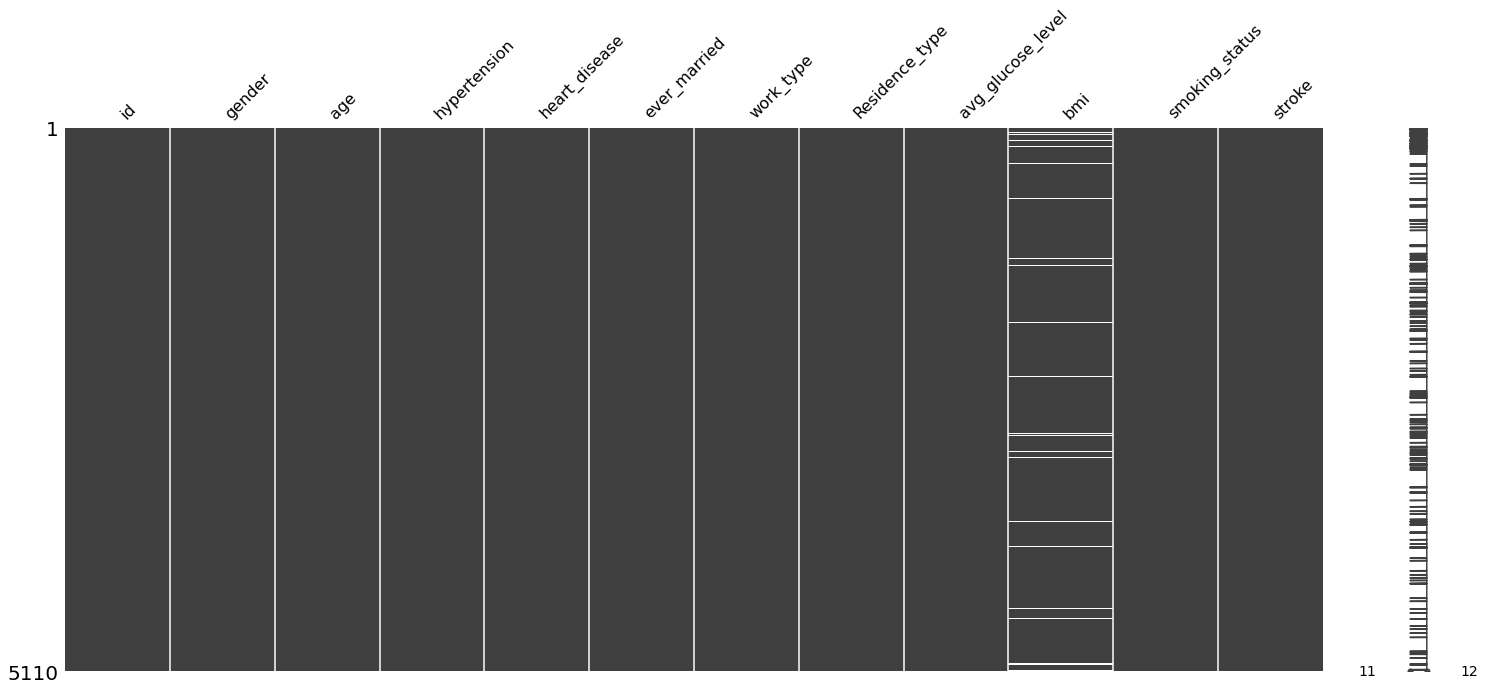

In [5]:
#Missing values
import missingno as msno
null_values= data.isnull().value_counts()
print(null_values)
msno.matrix(data)

When it comes to null values we see that bmi has 201 missing values and it's the only column that has missing values.
Rather than erasing 200+ data points, let's try and understand why some bmi values are missing.

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3618,22877,Male,0.16,0,0,No,children,Urban,114.71,17.4,Unknown,0
4021,8247,Male,0.16,0,0,No,children,Urban,109.52,13.9,Unknown,0
3968,41500,Male,0.16,0,0,No,children,Rural,69.79,13.0,Unknown,0
3392,11371,Male,0.24,0,0,No,children,Urban,89.28,14.2,Unknown,0
996,53279,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
2898,64974,Male,0.24,0,0,No,children,Urban,58.35,18.6,Unknown,0
4293,69222,Male,0.24,0,0,No,children,Urban,57.09,19.4,Unknown,0
1999,42500,Male,0.24,0,0,No,children,Rural,146.97,18.5,Unknown,0


<AxesSubplot:>

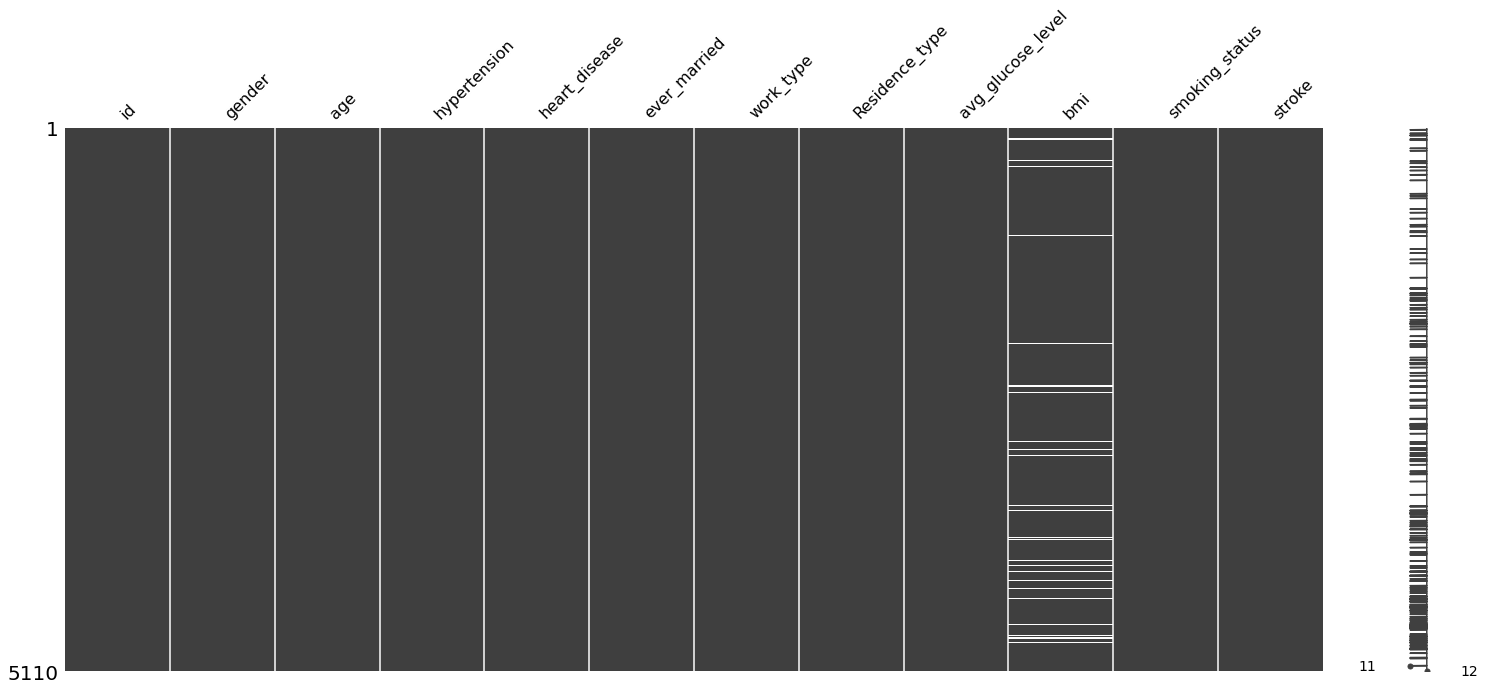

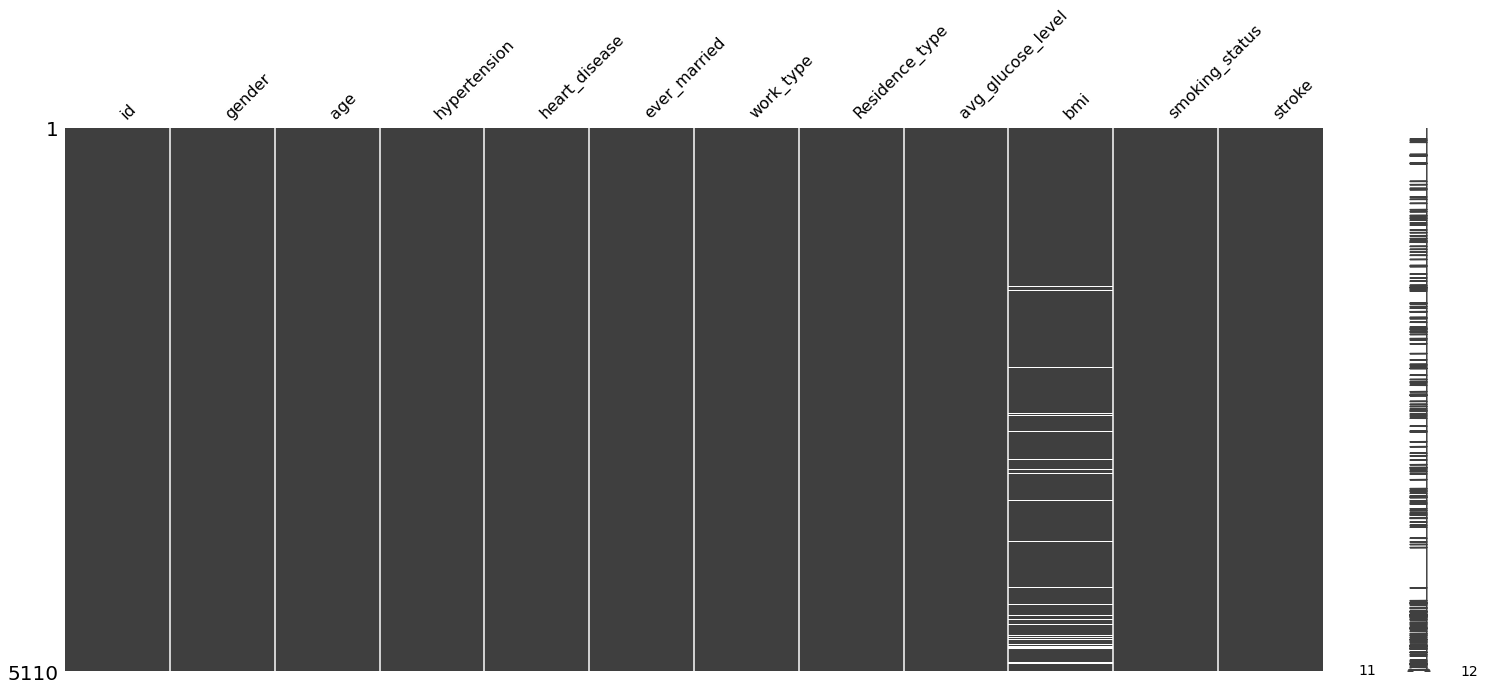

In [6]:
#Sort by age
age_sorted= data.sort_values(by= "age")
display(age_sorted.head(10))
msno.matrix(age_sorted)

#Sort by avg glucose level
gluc_sorted= data.sort_values(by= 'avg_glucose_level')
msno.matrix(gluc_sorted)

It seems as though older participants and those with higher average glucose levels tend to have missing bmi values.

In [7]:
#Number of males and females
print(data['gender'].value_counts())

#Categorize data according to gender and check that gender only has one of the two categories
data_female= data[data['gender']=='Female']
print(data_female['gender'].unique())
data_male= data[data['gender']=='Male']
print(data_male['gender'].unique())


#For female- number of null values in bmi
f_null_values= data_female['bmi'].isna().sum()
print("Rate of missing bmi values for females: " + str(round(((f_null_values/2994)*100),2))+ "%")

#For male
m_null_values= data_male['bmi'].isna().sum()
print("Rate of missing bmi values for males: " + str(round(((m_null_values/2115)*100),2)) + "%")

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
['Female']
['Male']
Rate of missing bmi values for females: 3.24%
Rate of missing bmi values for males: 4.92%


The difference isn't that obvious but let's do some more digging. Maybe plotting it would be more efficient.



## Age

       id  gender   age  hypertension  heart_disease ever_married  \
1   51676  Female  61.0             0              0          Yes   
8   27419  Female  59.0             0              0          Yes   
13   8213    Male  78.0             0              1          Yes   
19  25226    Male  57.0             0              1           No   
27  61843    Male  58.0             0              0          Yes   

        work_type Residence_type  avg_glucose_level  bmi smoking_status  \
1   Self-employed          Rural             202.21  NaN   never smoked   
8         Private          Rural              76.15  NaN        Unknown   
13        Private          Urban             219.84  NaN        Unknown   
19       Govt_job          Urban             217.08  NaN        Unknown   
27        Private          Rural             189.84  NaN        Unknown   

    stroke  
1        1  
8        1  
13       1  
19       1  
27       1  


<AxesSubplot:ylabel='Frequency'>

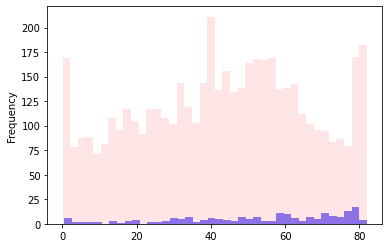

In [8]:
#Isolate data points with missing bmi values

missing_bmi= data[data['bmi'].isna()]
complete_bmi= data[~data['bmi'].isna()]
print(missing_bmi.head(5))

import matplotlib as plt

missing_bmi['age'].plot(kind= 'hist', bins= 40, color= 'blue', alpha= 0.5)
complete_bmi['age'].plot(kind= 'hist', bins= 40, color= 'red', alpha= 0.1)

<AxesSubplot:ylabel='Frequency'>

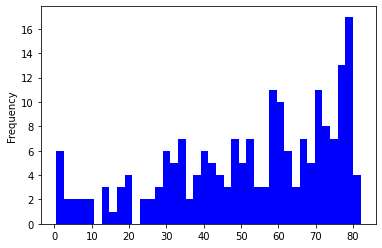

In [9]:
missing_bmi['age'].plot(kind= 'hist', bins= 40, color= 'blue')

## Hypertension

<AxesSubplot:ylabel='Frequency'>

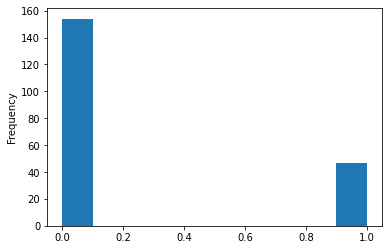

In [10]:
missing_bmi['hypertension'].plot(kind= 'hist')

<AxesSubplot:ylabel='Frequency'>

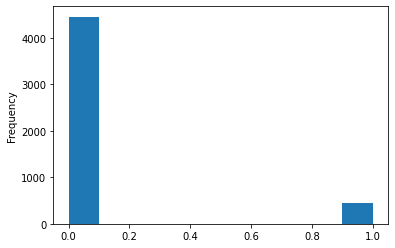

In [11]:
complete_bmi['hypertension'].plot(kind= 'hist')

## Heart disease

<AxesSubplot:ylabel='Frequency'>

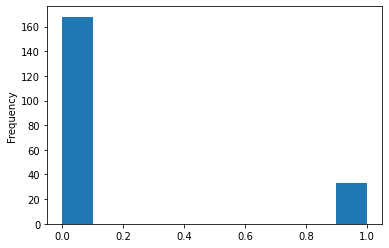

In [12]:
missing_bmi['heart_disease'].plot(kind= 'hist')

<AxesSubplot:ylabel='Frequency'>

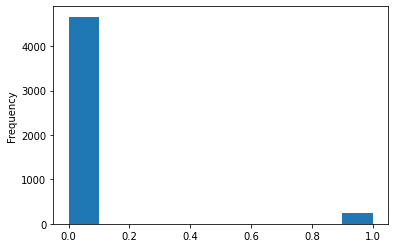

In [13]:
complete_bmi['heart_disease'].plot(kind= 'hist')

## Ever married

<AxesSubplot:>

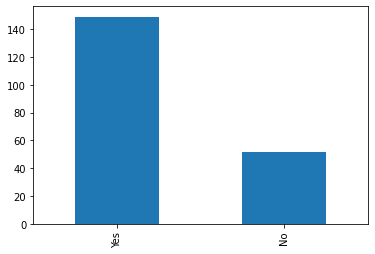

In [14]:
missing_bmi['ever_married'].value_counts().plot(kind= 'bar')

<AxesSubplot:>

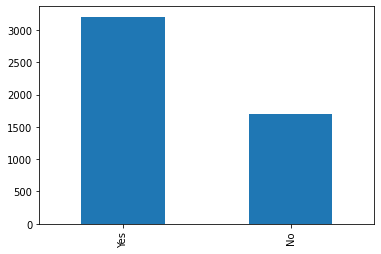

In [15]:
complete_bmi['ever_married'].value_counts().plot(kind= 'bar')

<AxesSubplot:>

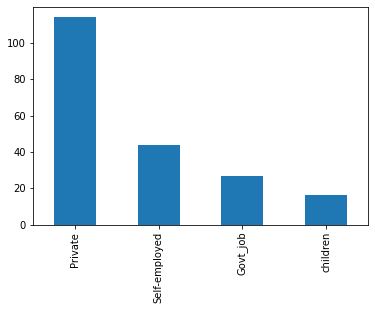

In [16]:
missing_bmi['work_type'].value_counts().plot(kind= 'bar')

<AxesSubplot:>

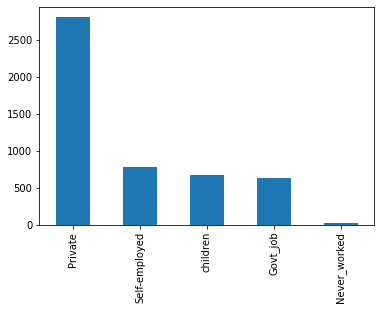

In [17]:
complete_bmi['work_type'].value_counts().plot(kind= 'bar')

<AxesSubplot:>

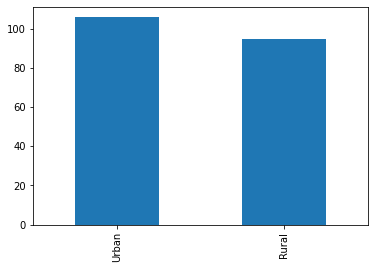

In [18]:
missing_bmi['Residence_type'].value_counts().plot(kind= 'bar')

<AxesSubplot:>

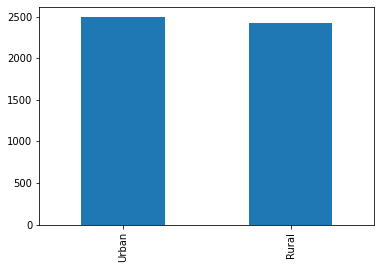

In [19]:
complete_bmi['Residence_type'].value_counts().plot(kind= 'bar')

<AxesSubplot:>

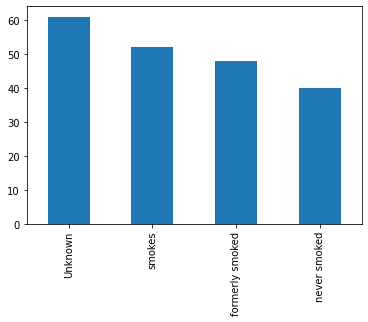

In [20]:
missing_bmi['smoking_status'].value_counts().plot(kind= 'bar')

<AxesSubplot:>

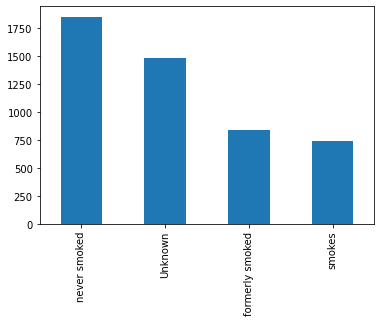

In [21]:
complete_bmi['smoking_status'].value_counts().plot(kind= 'bar')

<AxesSubplot:>

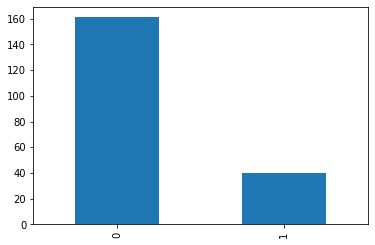

In [22]:
missing_bmi['stroke'].value_counts().plot(kind= 'bar')

<AxesSubplot:>

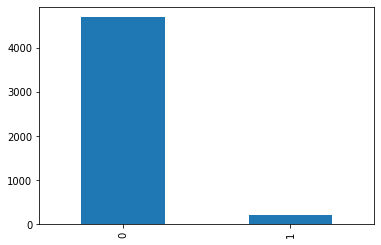

In [23]:
complete_bmi['stroke'].value_counts().plot(kind= 'bar')

From our plots we gather a few things:
* A higher number of stroke patients are made up of those with missing bmi data.
* Those with missing bmi values tend to have hypertension, history of heart disease, and are older people. 
* There's a noticeable number of them who are self-employed as well.

Since missing bmi values seem to have some significant correlation with the other values that are heavily correlated with the occurence of stroke. It would be wiser to input a value that is closer to those who are older, with hypertension, history of heart disease, and self-employed.
